In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F

from src2.CNN import CNNActionValue
from src2.evaluate import evaluate
import src2.DQN as DQN
from src2.Preprocess import preprocess, ImageEnv

In [2]:
env = gym.make('CarRacing-v3', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


(96, 96, 3)


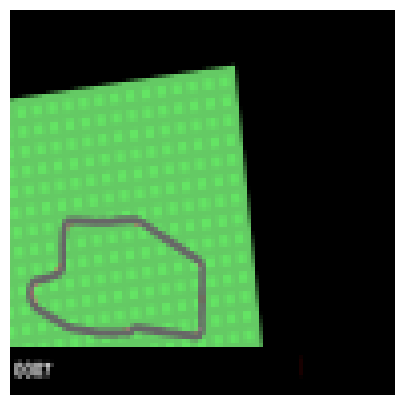

In [3]:
s, info = env.reset()
print(s.shape)

frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

The shape of an observation:  (4, 84, 84)


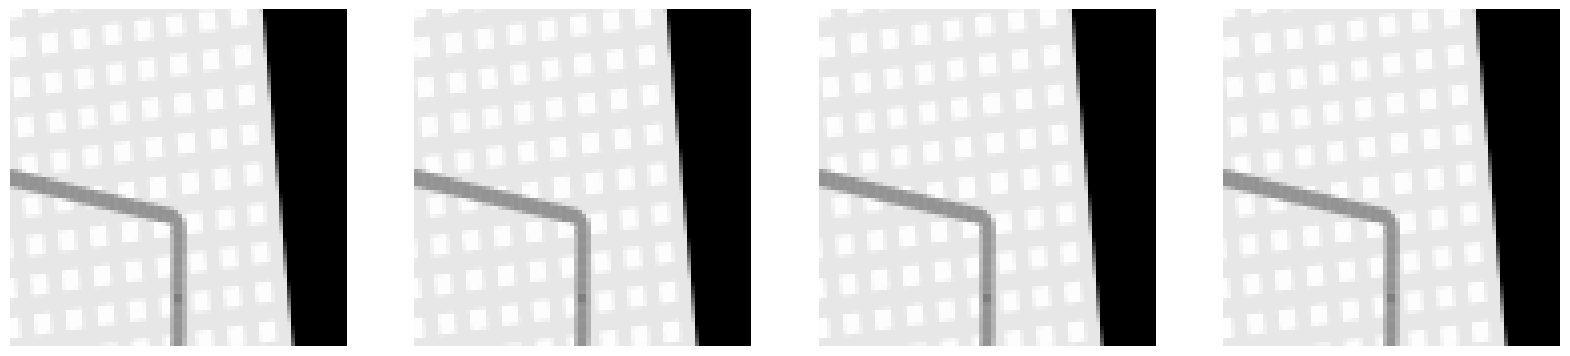

In [4]:
env = gym.make('CarRacing-v3', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

In [5]:
env = gym.make('CarRacing-v3', continuous=False)
env = ImageEnv(env)

max_steps = int(1e4)
eval_interval = 100
state_dim = (4, 84, 84)
action_dim = env.action_space.n

agent = DQN.DQN(state_dim, action_dim)

In [6]:
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v3', continuous=False)
    eval_env = ImageEnv(eval_env)
    
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

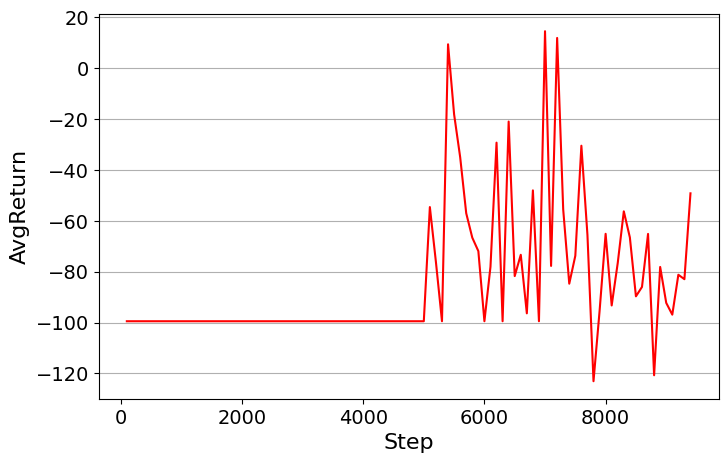

error: Out of memory

In [7]:
from IPython.display import clear_output

history = {'Step': [], 'AvgReturn': []}

(s, _) = env.reset()
while True:
    a = agent.act(s)
    s_prime, r, terminated, truncated, info = env.step(a)
    result = agent.process((s, a, r, s_prime, terminated))  # You can track q-losses over training from `result` variable.
    
    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()
        
    if agent.total_steps % eval_interval == 0:
        ret = evaluate()
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(ret)
        
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.savefig("AvgReturn_result2_02.jpg", dpi=300, bbox_inches='tight')
        plt.show()
        
        torch.save(agent.network.state_dict(), 'dqn.pt')
    
    if agent.total_steps > max_steps:
        break

In [ ]:
eval_env = gym.make('CarRacing-v3', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

In [ ]:
import matplotlib.animation as animation
fig = plt.figure()
ims = []

for frame in frames:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

# 애니메이션을 저장
ani.save('car_racing_result2_예비2.gif', writer='pillow')

plt.show()